In [1]:
# wd = '/mnt/openfact/users/msawinski/factue-task2'
wd = '/Users/marcinsawinski/Documents/GitHub/factue-task2'
import sys, os
os.chdir(wd)

In [2]:
from factue.methods.llm_calls import load_template_list
for x in load_template_list(job='persuasion', step="detect", prompt_version='v001').keys():
    print(f'"{x}"')

"Name_Calling-Labeling"
"Guilt_by_Association"
"Doubt"
"Appeal_to_Hypocrisy"
"Questioning_the_Reputation"
"Flag_Waving"
"Appeal_to_Authority"
"Appeal_to_Popularity"
"Appeal_to_Values"
"Appeal_to_Fear-Prejudice"
"Straw_Man"
"Red_Herring"
"Whataboutism"
"Appeal_to_Pity"
"Causal_Oversimplification"
"False_Dilemma-No_Choice"
"Consequential_Oversimplification"
"False_Equivalence"
"Slogans"
"Conversation_Killer"
"Appeal_to_Time"
"Loaded_Language"
"Obfuscation-Vagueness-Confusion"
"Exaggeration-Minimisation"
"Repetition"


In [3]:
import pandas as pd
from pathlib import Path
import os
root = Path("data/llm_output/persuasion/detect")
# Example path template
files = root.rglob("*/dev/*/*.parquet")

# Read all files and add file path as a column
df_list = []
for f in files:
    df_part = pd.read_parquet(f)
    df_part['source_file'] = f  # add the file path
    df_list.append(df_part)

# Combine into one DataFrame
df = pd.concat(df_list, ignore_index=True)
df['split'] = df.source_file.astype(str).str.split('/',expand=True)[7]
df['partno'] = df.source_file.astype(str).str.split('/',expand=True)[9].str.split('_',expand=True)[1].str.split('.',expand=True)[0].astype(int)

In [4]:
df['split'].value_counts()

split
dev    58310
Name: count, dtype: int64

In [5]:
df.head(3)

,filename,start,end,text_lang,text,label_bin,label_multi,base_split,Questioning_the_Reputation,Name_Calling-Labeling,...,extra_content,extra_properties,description,pred,gold,source_file,error,status,split,partno
0,pl_defence_22_05_2024_n01.txt,6716,7011,PL,Pójdźmy dalej. Pan mówi o dialogu z Niemcami.\...,True,[Questioning_the_Reputation],train,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
1,pl_abortion_11_04_2024_n01.txt,3909,4029,PL,Lewica składa ustawę dotyczącą dekryminalizacj...,True,"[Conversation_Killer, Appeal_to_Values, False_...",trial,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
2,pl_eu_12_06_2024_n02.txt,5588,5843,PL,Druga dotyczy pozycji pana prezydenta. Chciałe...,True,[Doubt],train,[],[],...,[None],[None],"[No, the Exaggeration – Minimisation technique...",0,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3


In [6]:
df.pred.value_counts()

pred
 0    37018
 1    19821
-1     1471
Name: count, dtype: int64

In [7]:
df[df.split=='dev'].groupby(["prompt_name","text_lang","model_name","split"])['filename'].agg("count").reset_index()

,prompt_name,text_lang,model_name,split,filename
0,Appeal_to_Authority,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,dev,184
1,Appeal_to_Authority,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,dev,100
2,Appeal_to_Authority,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,dev,184
3,Appeal_to_Authority,BG,gpt-4.1-mini,dev,100
4,Appeal_to_Authority,BG,gpt-4o-mini,dev,184
...,...,...,...,...,...
595,Whataboutism,SI,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,dev,41
596,Whataboutism,SI,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,dev,41
597,Whataboutism,SI,gpt-4.1-mini,dev,41
598,Whataboutism,SI,gpt-4o-mini,dev,41


In [8]:
def normalize_binary(x):
    return 1 if str(x).strip().lower() in {'1', 'true'} else 0

In [9]:
df['source_file'].value_counts().sort_index()
df['gold'] = df['gold'].apply(normalize_binary)
df['pred'] = df['pred'].apply(normalize_binary)
df['split'] = df.source_file.astype(str).str.split('/',expand=True)[7]

In [10]:
df.prompt_name.value_counts()

prompt_name
Questioning_the_Reputation          2336
Causal_Oversimplification           2336
Doubt                               2336
Whataboutism                        2336
Consequential_Oversimplification    2336
Guilt_by_Association                2336
Appeal_to_Time                      2336
False_Equivalence                   2336
Appeal_to_Authority                 2336
Flag_Waving                         2336
Obfuscation-Vagueness-Confusion     2336
Straw_Man                           2336
Appeal_to_Hypocrisy                 2336
Appeal_to_Pity                      2336
Red_Herring                         2336
Appeal_to_Fear-Prejudice            2336
Appeal_to_Values                    2336
False_Dilemma-No_Choice             2336
Appeal_to_Popularity                2336
Repetition                          2336
Conversation_Killer                 2326
Loaded_Language                     2316
Slogans                             2316
Name_Calling-Labeling               2316
Exag

In [11]:
df.pred.value_counts(dropna=False)

pred
0    38489
1    19821
Name: count, dtype: int64

In [12]:
df_all = df.copy()

In [13]:
df_all.model_name.value_counts()

model_name
llama3.1:8b                               10725
gpt-4o-mini                               10715
gpt-4-1-mini-2025-04-14-ft-pers_v2_r31    10325
gpt-4-1-mini-2025-04-14-ft-pers_v2_r11    10325
gpt-4.1-mini                               8120
gpt-4-1-mini-2025-04-14-ft-pers_v2_r21     8100
Name: count, dtype: int64

In [14]:
# df = df_all[(df_all['partno']<4)&(df_all['model_name'].isin(['gpt-4-1-mini-2025-04-14-ft-pers_v2_r11','gpt-4-1-mini-2025-04-14-ft-pers_v2_r21','gpt-4-1-mini-2025-04-14-ft-pers_v2_r31','gpt-4.1-mini']))]
df = df_all
df

,filename,start,end,text_lang,text,label_bin,label_multi,base_split,Questioning_the_Reputation,Name_Calling-Labeling,...,extra_content,extra_properties,description,pred,gold,source_file,error,status,split,partno
0,pl_defence_22_05_2024_n01.txt,6716,7011,PL,Pójdźmy dalej. Pan mówi o dialogu z Niemcami.\...,True,[Questioning_the_Reputation],train,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
1,pl_abortion_11_04_2024_n01.txt,3909,4029,PL,Lewica składa ustawę dotyczącą dekryminalizacj...,True,"[Conversation_Killer, Appeal_to_Values, False_...",trial,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
2,pl_eu_12_06_2024_n02.txt,5588,5843,PL,Druga dotyczy pozycji pana prezydenta. Chciałe...,True,[Doubt],train,[],[],...,[None],[None],"[No, the Exaggeration – Minimisation technique...",0,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
3,pl_abortion_11_04_2024_n07.txt,8852,9116,PL,"(Wypowiedź poza mikrofonem)\nTak, dziękuję pań...",False,[],train,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
4,pl_abortion_11_04_2024_n03.txt,5206,6143,PL,Na przełomie lat 90. i 2000. kwitło podziemie\...,True,"[Loaded_Language, Appeal_to_Hypocrisy, Appeal_...",train,[],[],...,[None],[None],"[Yes, the Exaggeration – Minimisation techniqu...",1,0,data/llm_output/persuasion/detect/GPT_41_MINI_...,NaN,NaN,dev,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58305,trail_BG_1.txt,6965,7030,BG,"дател. \n\nГосподин Чорбанов, Вие казахте, че ...",False,[],trial,[],[],...,[None],[None],"[Текстът не предоставя достатъчно информация, ...",0,0,data/llm_output/persuasion/detect/GPT_4O_MINI/...,NaN,NaN,dev,3
58306,20231208_URW_BG_73.txt,1146,1847,BG,Нека един път завинаги да разбием тази ужасна ...,True,"[False_Equivalence, Loaded_Language, Name_Call...",train,[],"[ужасна глупост, отвратително гнусна опорка на...",...,[None],[None],"[Текстът съдържа техниката Strawman, тъй като ...",1,0,data/llm_output/persuasion/detect/GPT_4O_MINI/...,NaN,NaN,dev,3
58307,trail_BG_2.txt,4796,5182,BG,момента за пореден път? Не е първият законопро...,True,"[Slogans, Name_Calling-Labeling]",trial,[],[],...,[None],[None],[The text does not explicitly use the Strawman...,0,0,data/llm_output/persuasion/detect/GPT_4O_MINI/...,NaN,NaN,dev,3
58308,trail_BG_2.txt,5244,5288,BG,"яма втора реплика. \n\nЗаповядайте за дуплика,",False,[],trial,[],[],...,[None],[None],[The text does not contain a clear argument or...,0,0,data/llm_output/persuasion/detect/GPT_4O_MINI/...,NaN,NaN,dev,3


In [15]:
# df = df_all[(df_all['partno']<4)&(df_all['text_lang']=='PL')&(df_all['model_name'].isin(['gpt-4-1-mini-2025-04-14-ft-pers_v2_r21','gpt-4-1-mini-2025-04-14-ft-pers_v2_r31','gpt-4.1-mini']))]
# df

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for prompt_name in df['prompt_name'].unique():
    for text_lang in df.loc[df['prompt_name'] == prompt_name, 'text_lang'].unique():
        for model_name in df.loc[(df['prompt_name'] == prompt_name) & (df['text_lang'] == text_lang), 'model_name'].unique():
            group = df[
                (df['prompt_name'] == prompt_name) &
                (df['text_lang'] == text_lang) &
                (df['model_name'] == model_name)
            ]
            if len(group) > 0:
                row = {
                    'prompt_name': prompt_name,
                    'text_lang': text_lang,
                    'model_name': model_name,
                    'accuracy': accuracy_score(group['gold'], group['pred']),
                    'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                    'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                    'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                    'support': len(group)
                }
                rows.append(row)

results = pd.DataFrame(rows)
results[['accuracy', 'precision','recall', 'f1']] = results[['accuracy', 'precision','recall', 'f1']].round(2)
results

,prompt_name,text_lang,model_name,accuracy,precision,recall,f1,support
0,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,0.58,0.12,0.86,0.22,103
1,Exaggeration-Minimisation,PL,gpt-4.1-mini,0.60,0.13,0.86,0.23,100
2,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.63,0.14,0.86,0.24,100
3,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.59,0.13,0.86,0.22,103
4,Exaggeration-Minimisation,PL,llama3.1:8b,0.45,0.10,1.00,0.18,114
...,...,...,...,...,...,...,...,...
595,Straw_Man,BG,gpt-4.1-mini,0.87,0.14,0.67,0.24,100
596,Straw_Man,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.86,0.13,0.67,0.22,100
597,Straw_Man,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.88,0.08,0.67,0.15,184
598,Straw_Man,BG,llama3.1:8b,0.72,0.04,0.67,0.07,184


In [17]:
pivoted = results.pivot_table(
    index='prompt_name',
    columns='model_name',
    values=['accuracy', 'precision', 'recall', 'f1']
)
pivoted.columns = [f"{model}_{metric}" for metric, model in pivoted.columns]
pivoted = pivoted.reset_index()
pivoted

,prompt_name,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11_accuracy,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21_accuracy,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31_accuracy,gpt-4.1-mini_accuracy,gpt-4o-mini_accuracy,llama3.1:8b_accuracy,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11_f1,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21_f1,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31_f1,...,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31_precision,gpt-4.1-mini_precision,gpt-4o-mini_precision,llama3.1:8b_precision,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11_recall,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21_recall,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31_recall,gpt-4.1-mini_recall,gpt-4o-mini_recall,llama3.1:8b_recall
0,Appeal_to_Authority,0.8475,0.8500,0.8525,0.8575,0.8525,0.6850,0.1875,0.1600,0.1875,...,0.1600,0.1575,0.1475,0.1400,0.2575,0.2600,0.2575,0.2950,0.2225,0.4150
1,Appeal_to_Fear-Prejudice,0.7325,0.7450,0.7250,0.7275,0.7275,0.5275,0.3900,0.4000,0.3450,...,0.2425,0.2750,0.2825,0.1800,0.9375,0.9125,0.7975,0.9125,0.9250,0.8875
2,Appeal_to_Hypocrisy,0.9075,0.9100,0.9275,0.9125,0.9100,0.5750,0.4350,0.4025,0.4800,...,0.4000,0.3450,0.3225,0.1300,0.7425,0.7500,0.7425,0.7500,0.7425,0.9550
3,Appeal_to_Pity,0.9325,0.9425,0.9525,0.9400,0.9350,0.6450,0.3550,0.4275,0.4825,...,0.4300,0.3050,0.3075,0.1250,0.4550,0.5800,0.5800,0.4550,0.4500,0.5925
4,Appeal_to_Popularity,0.8925,0.8975,0.9000,0.8925,0.8850,0.5925,0.2625,0.3475,0.3600,...,0.3850,0.2250,0.2150,0.1475,0.2800,0.5475,0.5625,0.2450,0.4675,0.8500
5,Appeal_to_Time,0.8425,0.8625,0.8500,0.8575,0.8750,0.8600,0.2225,0.2450,0.2225,...,0.1425,0.1675,0.1725,0.1000,0.7200,0.7200,0.7200,0.7200,0.7200,0.3125
6,Appeal_to_Values,0.7650,0.7475,0.7450,0.7425,0.7350,0.6325,0.4725,0.4775,0.4450,...,0.3650,0.3750,0.3650,0.3300,0.9150,0.9300,0.8750,0.8875,0.8950,0.7275
7,Causal_Oversimplification,0.6125,0.6025,0.5925,0.6050,0.6000,0.6625,0.1425,0.1525,0.1325,...,0.0750,0.0875,0.0850,0.0875,0.6150,0.6500,0.6000,0.6500,0.6500,0.5925
8,Consequential_Oversimplification,0.7825,0.7900,0.7775,0.7800,0.7775,0.5950,0.1725,0.2050,0.1600,...,0.0975,0.1225,0.1275,0.0675,0.5825,0.5825,0.5000,0.5825,0.7075,0.7300
9,Conversation_Killer,0.4900,0.5050,0.4875,0.5000,0.5000,0.3225,0.1550,0.1375,0.1450,...,0.0875,0.0775,0.1025,0.0725,0.7500,0.7500,0.7325,0.7325,0.7375,0.6800


In [18]:
pivoted.sort_values(by="gpt-4-1-mini-2025-04-14-ft-pers_v2_r21_f1", ascending=False)['prompt_name'].to_list()

['Loaded_Language',
 'Appeal_to_Values',
 'Appeal_to_Pity',
 'Appeal_to_Hypocrisy',
 'Appeal_to_Fear-Prejudice',
 'Questioning_the_Reputation',
 'Appeal_to_Popularity',
 'Doubt',
 'Name_Calling-Labeling',
 'Exaggeration-Minimisation',
 'Whataboutism',
 'Repetition',
 'Slogans',
 'Appeal_to_Time',
 'Straw_Man',
 'Red_Herring',
 'Flag_Waving',
 'Consequential_Oversimplification',
 'Appeal_to_Authority',
 'Causal_Oversimplification',
 'Guilt_by_Association',
 'Conversation_Killer',
 'False_Equivalence',
 'Obfuscation-Vagueness-Confusion',
 'False_Dilemma-No_Choice']

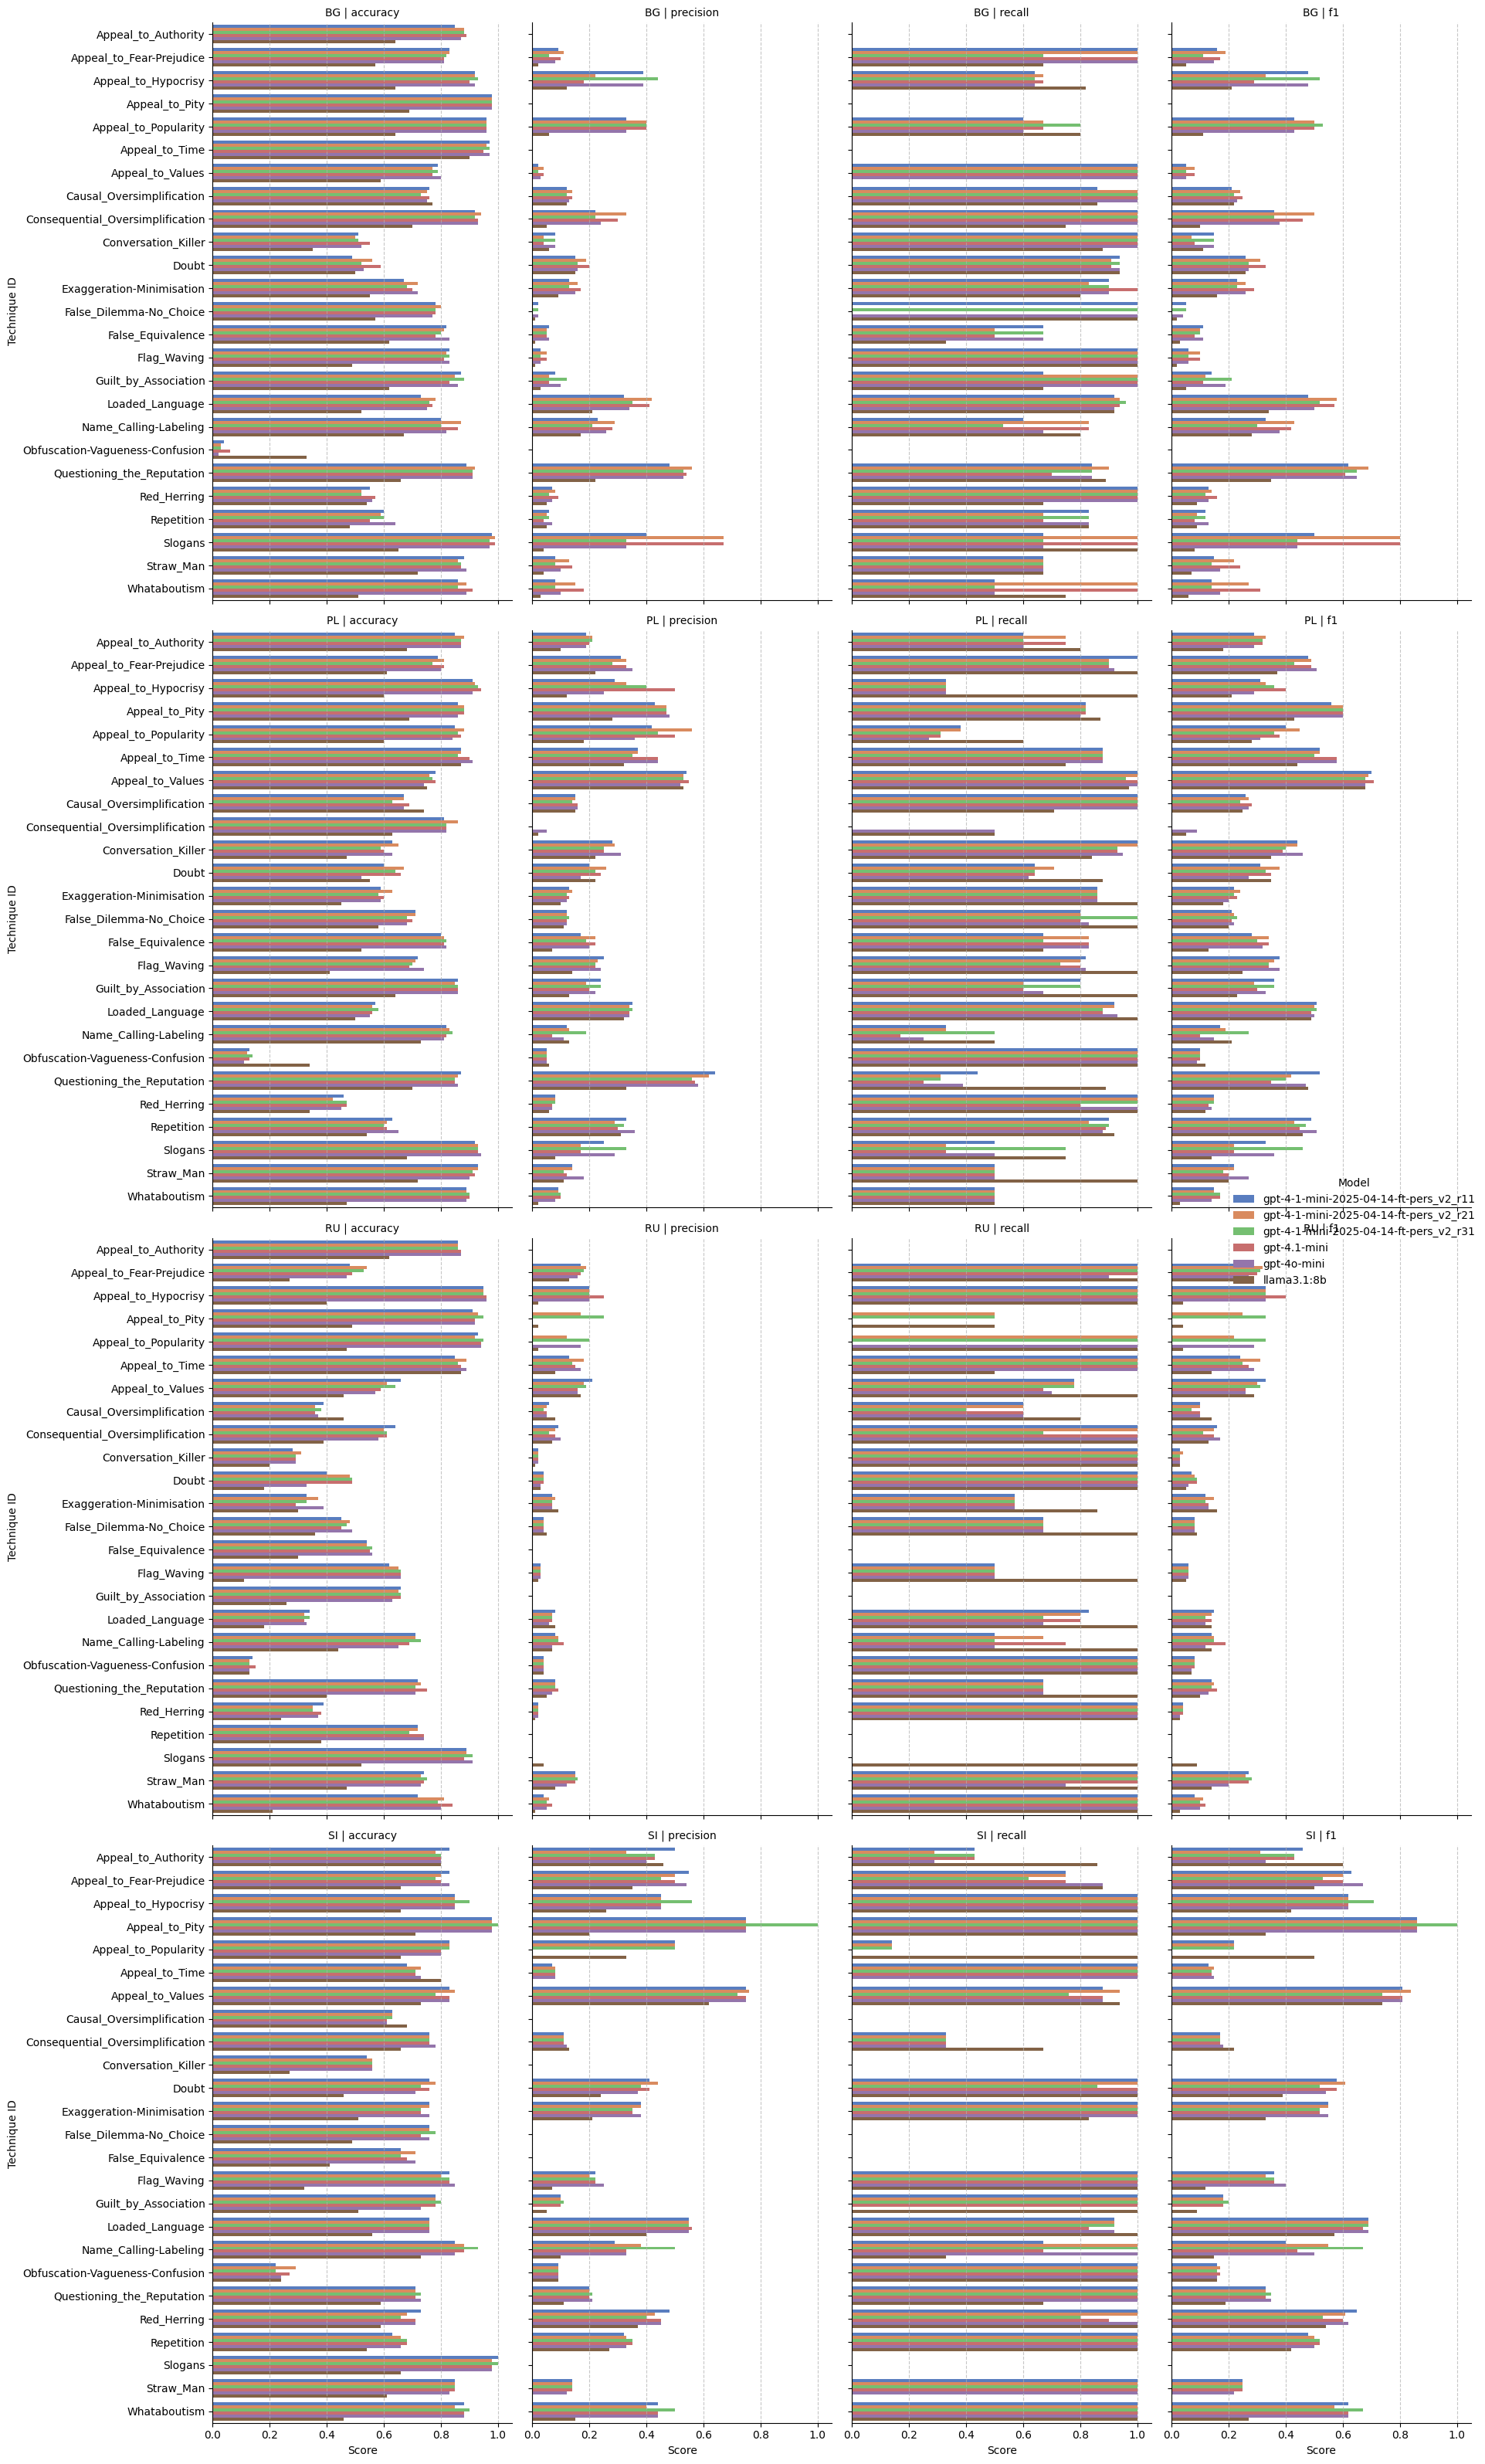

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the results dataframe
metrics_df = results.melt(
    id_vars=['prompt_name', 'text_lang', 'model_name'],
    value_vars=['accuracy', 'precision', 'recall', 'f1'],
    var_name='metric',
    value_name='score'
).sort_values(['prompt_name', 'text_lang', 'model_name'])

# Create FacetGrid
g = sns.FacetGrid(
    metrics_df, 
    row="text_lang", 
    col="metric", 
    sharex=True, 
    sharey=True, 
    height=8, 
    aspect=0.5
)

# Use map_dataframe and assign `hue` in the barplot call
g.map_dataframe(
    sns.barplot, 
    x="score", 
    y="prompt_name", 
    hue="model_name", 
    errorbar=None, 
    palette='muted',
    # legend=False  # Disable auto-legend here
)
# for i, ax in enumerate(g.axes.flat):
#     row_idx, col_idx = divmod(i, g.axes.shape[1])
#     if col_idx != 0:
#         ax.set_ylabel("")
#         ax.set_yticklabels([])

# Add a single legend to the full figure
g.add_legend(title='Model')
g.set_axis_labels("Score", "Technique ID")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# total

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for text_lang in df['text_lang'].unique():
    for model_name in df.loc[(df['text_lang'] == text_lang), 'model_name'].unique():
        group = df[
            (df['text_lang'] == text_lang) &
            (df['model_name'] == model_name)
        ]
        if len(group) > 0:
            row = {
                'text_lang': text_lang,
                'model_name': model_name,
                'accuracy': accuracy_score(group['gold'], group['pred']),
                'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                'support': len(group)
            }
            rows.append(row)

results_total = pd.DataFrame(rows)
results_total[['accuracy', 'precision','recall', 'f1']] = results_total[['accuracy', 'precision','recall', 'f1']].round(2)
results_total

,text_lang,model_name,accuracy,precision,recall,f1,support
0,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,0.74,0.23,0.76,0.35,2575
1,PL,gpt-4.1-mini,0.75,0.23,0.74,0.35,2500
2,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.75,0.23,0.76,0.36,2500
3,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.74,0.23,0.78,0.36,2575
4,PL,llama3.1:8b,0.59,0.17,0.88,0.29,2850
5,PL,gpt-4o-mini,0.74,0.23,0.76,0.36,2850
6,RU,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,0.62,0.06,0.73,0.12,2125
7,RU,gpt-4.1-mini,0.62,0.06,0.74,0.12,2095
8,RU,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.62,0.07,0.78,0.12,2075
9,RU,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.61,0.06,0.75,0.11,2125


# lang


In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Define a function to compute metrics for a group
# Assume df has columns: prompt_name, text_lang, gold, pred
rows = []

def is_valid_label(x):
    return x in (0, 1)

rows = []

for prompt_name in df['prompt_name'].unique():
    for text_lang in df.loc[df['prompt_name'] == prompt_name, 'text_lang'].unique():
        for model_name in df.loc[(df['prompt_name'] == prompt_name) & (df['text_lang'] == text_lang), 'model_name'].unique():
            group = df[
                (df['prompt_name'] == prompt_name) &
                (df['text_lang'] == text_lang) &
                (df['model_name'] == model_name)
            ]
            if len(group) > 0:
                row = {
                    'prompt_name': prompt_name,
                    'text_lang': text_lang,
                    'model_name': model_name,
                    'accuracy': accuracy_score(group['gold'], group['pred']),
                    'precision': precision_score(group['gold'], group['pred'], zero_division=0),
                    'recall': recall_score(group['gold'], group['pred'], zero_division=0),
                    'f1': f1_score(group['gold'], group['pred'], zero_division=0),
                    'support': len(group)
                }
                rows.append(row)

results = pd.DataFrame(rows)
results[['accuracy', 'precision','recall', 'f1']] = results[['accuracy', 'precision','recall', 'f1']].round(2)
results

,prompt_name,text_lang,model_name,accuracy,precision,recall,f1,support
0,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r31,0.58,0.12,0.86,0.22,103
1,Exaggeration-Minimisation,PL,gpt-4.1-mini,0.60,0.13,0.86,0.23,100
2,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.63,0.14,0.86,0.24,100
3,Exaggeration-Minimisation,PL,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.59,0.13,0.86,0.22,103
4,Exaggeration-Minimisation,PL,llama3.1:8b,0.45,0.10,1.00,0.18,114
...,...,...,...,...,...,...,...,...
595,Straw_Man,BG,gpt-4.1-mini,0.87,0.14,0.67,0.24,100
596,Straw_Man,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r21,0.86,0.13,0.67,0.22,100
597,Straw_Man,BG,gpt-4-1-mini-2025-04-14-ft-pers_v2_r11,0.88,0.08,0.67,0.15,184
598,Straw_Man,BG,llama3.1:8b,0.72,0.04,0.67,0.07,184
